# Entry for the 2nd KRX Stock Investment Algorithm Competition

- Written by: **Estimation Company**
- Team Leader: **Kim Hyun-jun** (Soongsil University, Department of Finance, Papers SSU)
- Team Member: **Kim Jun-hwi** (Soongsil University, Department of Finance, Papers SSU)
- Contact: [hyeonjunacademic@gmail.com](mailto:hyeonjunacademic@gmail.com)
- Documentation Date: **July 29, 2023**

## Our Model

The foundation of our model is based on the risk-based asset pricing model. We used a regularized linear model to predict cross-sectional returns by utilizing factors that can act as potential systematic risks for each stock. Regularization is a technique to prevent model parameter values from becoming too large, artificially adjusting to ensure accurate estimation while reducing the parameter estimation error. This is especially useful for noisy financial data.

We used potential technical indicators that can cause differences in cross-sectional returns and various macroeconomic market price indicators and surveys (sentiment, questionnaires) that can be considered as systematic risks. To estimate the magnitude of the risk, we used a risk proxy estimation method similar to Ross's APT. This means:

$$ R_t^{(i)} = \alpha + \beta_{j} F_t^{(j)} + \epsilon $$

In a linear regression model like above, we estimate $ \beta_{j} $ using OLS simple linear regression and consider this unbiased estimator as a risk proxy. Here, $ R_t^{(i)}$ is the return of the i-th stock at time t, and $ F_t^{(j)}$ is the j-th risk factor at time t. An unbiased estimator, unlike the parameter in the regularized model, means that even if there's a noisy part during the risk proxy estimation, we will adopt a parameter that is not biased without regularization.

Traditionally, to use a cross-sectional return explanation model, it's customary to use the Fama Macbeth Regression to derive regression coefficients for each risk proxy cross-sectionally and use the time series average. However, considering the technical characteristics of this competition, our project intends to input all data at all times and estimate only one model parameter. This means that we're not viewing each time point differently; instead, we treat all time points as a single consistent time. This is somewhat feasible because each risk proxy is stationary, implying that its distribution is constant regardless of the time point.

In our research findings, movements that go against what is predicted by our risk pricing model were observed.

If this result occurred due to a simple behavioral economic reason, the phenomenon could not be persistent. However, in our research with the provided dataset, a strong mean-reversion phenomenon was consistently observed. We propose the following financial-economic explanations for this anomaly:

1. All risk proxies currently used are already reflected in market prices. Therefore, stocks that the model evaluated to have significant cross-sectional return differences due to risk proxies had an overreaction to that particular risk, causing the return to move in the opposite direction to the predicted return for rebalancing to the equilibrium price.

2. When a risk proxy that has shown strong influence across the market rises, the future returns priced in increase. However, in actual short-term situations, the risk increases, resulting in a decrease in price. Thus, while the prediction of the model signifies long-term equilibrium returns, the short investment period of about a month sees the price drop phase due to the rise of the risk proxy occurring first.

Our team aims to maximize returns through technical manipulation, along with a clear financial-economic explanation for the observed anomalies.


Pandas Version : 1.4.4

Numpy Version : 1.24.3

Matplotlib Version : 3.7.1

Seaborn Version : 0.12.0

Statsmodels Version : 0.13.2

tqdm Version : 4.65.0

Sklearn Version : 1.1.2


In [1]:
#필요한 모듈 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from tqdm import tqdm
from sklearn.linear_model import Ridge
import warnings
warnings.filterwarnings('ignore')

## Importing & Processing External Data

All data was obtained from the Bank of Korea's Economic Statistics System (ECOS). To ensure no data leakage (or look forward bias) existed, the data needed to be processed. The code below carries out such processing.


In [2]:
# Load survey data and perform partial preprocessing
# First, even if the survey data shows stationarity, it is necessary to difference it for comparison with stock returns.
# Therefore, we intend to observe the effect of differencing using the rate of change.
# However, in some surveys, the value itself may hold meaningful information, so using non-differenced values for prediction could also be an alternative.

sur = pd.read_csv("survey.csv", index_col=0, parse_dates=True).resample("m").last().pct_change()
sur.loc[pd.to_datetime("2023-07-31", format="%Y-%m-%d"), :] = np.nan
# Since survey data is often released for the following month,
# utilizing data from 2 months ago for predicting current period's returns is appropriate.

sur = sur.shift(2)
sur

,뉴스심리지수,경제심리지수,소비자물가지수,생산자물가지수
통계표,,,,
2006-09-30,NaN,NaN,NaN,NaN
2006-10-31,NaN,NaN,NaN,NaN
2006-11-30,NaN,NaN,NaN,NaN
2006-12-31,-0.031591,0.022430,-0.004839,-0.009221
2007-01-31,0.008232,0.001828,-0.004850,-0.004826
...,...,...,...,...
2023-03-31,0.124715,-0.015301,0.007504,0.003840
2023-04-30,0.039343,0.016648,0.002543,0.001746
2023-05-31,-0.033956,-0.001092,0.001631,0.001079


In [3]:
# Load market price data
# There is an issue with the index of the market price data,
# so it is necessary to change it to a datetime object index.
mar = pd.read_csv("markets.csv", index_col=0, parse_dates=True).iloc[::-1, :]
mar.index = pd.date_range("2006-09", "2023-07", freq="m")
mar.loc[pd.to_datetime("2023-07-31", format="%Y-%m-%d"), :] = np.nan
# Market data is automatically released at the end of each month,
# so using the previous month's data is possible to calculate the returns for the current month.
# Therefore, we only shift by 1.
mar = mar.shift(1)
# Process for calculating the government bond yield spread
mar["spread"] = mar["국고채10"] - mar["국고채3"]
mar = mar.drop(["국고채10", "국고채3"], axis=1)
# Differencing of price data
mar.iloc[:, :4] = mar.iloc[:, :4].pct_change()
# Differencing of interest rate data
mar.iloc[:, -2:] = mar.iloc[:, -2:].diff()

In [4]:
# Merging survey data and market price data
df1 = pd.concat([sur, mar], axis=1)
df1.tail(5)

,뉴스심리지수,경제심리지수,소비자물가지수,생산자물가지수,미국달러,위안,일본엔,유로,통안증권,spread
2023-03-31,0.124715,-0.015301,0.007504,0.003840,0.072190,0.036795,0.026682,0.048716,0.004,0.029
2023-04-30,0.039343,0.016648,0.002543,0.001746,-0.010323,0.001801,0.014555,0.017006,-0.030,0.007
2023-05-31,-0.033956,-0.001092,0.001631,0.001079,0.027688,0.022418,0.019553,0.039472,-0.193,0.069
2023-06-30,0.009132,0.025137,0.002171,-0.000746,-0.013210,-0.036510,-0.054616,-0.039692,0.137,0.016
2023-07-31,0.015679,0.004264,0.002978,-0.003900,-0.007109,-0.028233,-0.041238,0.005328,0.140,-0.009


## Preprocessing Default Provided Competition Data

The provided data is technical data, and we intend to use only the closing prices and trading volumes of each stock.


In [5]:
#competition data load
X00 = pd.read_csv("train.csv")
X000 = pd.read_csv("train_additional.csv")

X00 = pd.concat([X00, X000], axis=0)
#close price pannel data 
X = X00.pivot(columns="종목코드", index="일자", values="종가")
# trading volume pannel data
Y = X00.pivot(columns="종목코드", index="일자", values="거래량")
#index to datetime index
X.index = pd.to_datetime(X.index.astype(str), format="%Y%m%d")
Y.index = pd.to_datetime(Y.index.astype(str), format="%Y%m%d")
X0 = X.copy()
X = X.pct_change()

In [6]:
ret0 = X
#daily return to monthly return
ret = np.expm1(np.log1p(ret0).resample("m").sum()) * np.where(ret0.resample("m").last().isna(), np.nan, 1)
ret.tail(5)

종목코드,A000020,A000040,A000050,A000070,A000080,A000100,A000120,A000140,A000150,A000180,...,A363280,A365590,A368770,A369370,A373200,A375500,A378850,A383220,A383310,A383800
일자,,,,,,,,,,,,,,,,,,,,,
2023-03-31,-0.078714,-1.562500e-02,-0.024590,-0.044416,-0.062762,-0.039848,-0.022032,-0.066398,-0.030693,-0.102778,...,-0.152800,0.738648,-7.473842e-03,-0.066514,-0.264192,-0.019697,0.047436,0.004320,0.475000,1.925543e-16
2023-04-30,0.008424,3.293651e-01,-0.014006,0.003984,-0.006696,0.138340,-0.035044,-0.011853,-0.048008,0.006192,...,0.019830,0.081254,5.271084e-02,-0.022113,-0.252226,0.088099,-0.034272,0.010753,-0.129074,-1.172333e-03
2023-05-31,0.145585,2.463307e-16,-0.017992,-0.066138,0.029213,0.029514,0.057069,0.052345,0.043991,0.023077,...,-0.038889,0.135266,7.892992e-17,-0.045226,-0.086310,0.031250,0.107731,-0.082270,-0.068862,-3.873239e-02
2023-06-30,0.082292,-1.164179e-01,-0.041466,0.028329,-0.056769,0.018550,-0.062577,-0.035233,-0.068859,0.092732,...,-0.211946,-0.055319,4.048641e-01,-0.091053,0.357220,-0.042700,0.060641,-0.075734,-0.004823,-3.296703e-02
2023-07-31,-0.056785,-1.824324e-01,-0.032193,-0.044077,-0.071759,0.147351,-0.044503,-0.051557,-0.030905,-0.073394,...,-0.165037,-0.140140,-1.374745e-01,-0.079328,-0.240800,-0.126619,-0.090615,-0.154682,0.410339,3.914141e-02


## OLS Estimation Process for Risk Proxy Estimation

The following code treats survey and market price data as risk factors and extracts the risk proxy for each stock.


In [7]:

betas = None

for n in tqdm(range(len(df1.columns))):
    def factor_loading(array):

        beta = {}

        temp_df = sm.add_constant(pd.DataFrame(df1.iloc[:, n]))
        temp_df["y"] = array
        temp_df.dropna(inplace=True)

            # conduct regression
        results = sm.OLS(temp_df["y"], temp_df.drop("y", axis=1)).fit()

            # extract beta
        b = results.params
        b = pd.Series(b).drop(['const'])


        return float(b)

    tmp = ret.iloc[:, :].rolling(18).apply(factor_loading).shift(1)

    tmp = tmp.reset_index().melt(id_vars="일자", value_vars=tmp.columns).dropna()

    tmp = tmp.rename({"value":df1.columns[n]}, axis=1)

    if betas is None:
        
        betas = tmp.copy()
        
    else:
        
        betas = betas.merge(tmp, on=["일자", "종목코드"])

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [07:15<00:00, 43.52s/it]


In [8]:
#delete observation with failed estimation
betas = betas.dropna()
betas.tail(5)

,일자,종목코드,뉴스심리지수,경제심리지수,소비자물가지수,생산자물가지수,미국달러,위안,일본엔,유로,통안증권,spread
15995,2023-03-31,A383800,0.131508,0.193866,-10.975110,-2.724799,0.421121,0.774417,0.148649,0.696619,-0.035349,-0.227246
15996,2023-04-30,A383800,0.115993,0.064487,-10.527893,-2.580538,0.367065,0.760473,0.216281,0.520013,-0.047132,-0.228313
15997,2023-05-31,A383800,0.079336,0.260672,-9.997425,-2.486296,0.397905,0.887348,0.241875,0.492502,-0.055748,-0.166807
15998,2023-06-30,A383800,0.087678,0.229949,-8.954595,-2.233998,0.353774,0.767213,0.113625,0.237942,-0.010352,-0.190991
15999,2023-07-31,A383800,0.107230,-0.184679,-6.292767,-3.690655,0.296427,0.506153,-0.089170,0.626185,0.009231,0.050363


In [9]:
#trading volume resampled to month by adding daily volume within a month
Y = Y.resample("m").sum()

In [10]:
# Winsorizing Function
# Winsorizing refers to replacing extreme values in the data distribution with specific threshold values.
# Here, we identify the top and bottom 0.5% returns for each cross-section and replace them with the top and bottom 0.5% returns of each cross-sectional return.
# This can help mitigate distortion in estimation when dealing with actual observed data, and it has a stabilizing effect on the estimates.
# Of course, the Winsorized data is used for training and validation purposes, and it doesn't impact the scoring process for both public and private evaluation.

def winsor(series):
    
    series0 = series.copy()
    
    series0 = series0.where(series0 < series0.quantile(0.995), series0.quantile(0.995))
    series0 = series0.where(series0 > series0.quantile(0.005), series0.quantile(0.005))
    
    return series0

In [11]:
ret0 = ret.copy()
ret = ret.apply(winsor, axis=1)

## Development of Custom Indicators

The team has developed several custom cross-sectional return prediction indicators in addition to survey and market price data. However, these indicators have been found to be highly unstable, thus they function more as auxiliary indicators.

* ESBI-based Strategy

ESBI is our team's research result, which is an index composed of stocks similar to each individual stock and can serve as a proxy for its systematic risk. This indicator can also incorporate specific systematic risk factors of each stock, such as characteristics related to value/growth, small/large caps, and industries. ESBI can potentially be used as an approximation for more useful systematic risk compared to the KOSPI index.

There can be several specific strategies using this index, a few of which are:

First, more precisely measure the size of idiosyncratic risk to effectively reflect the low volatility anomaly in the model. (Low Volatility Strategy)

Second, measure the average of extreme abnormal returns to detect market inefficiencies and utilize it for future expected return predictions. This can be achieved by measuring the conditional expectation value based on the magnitude of abnormal returns exceeding a certain significance level (two-tailed 5%). (Conditional Expectation Strategy)

* Momentum and Liquidity-based Strategy

In general, many markets exhibit momentum or contrarian phenomena, and stocks with low liquidity are known to carry higher risk. To incorporate this into cross-sectional return prediction, the team utilized standardized 12-month return momentum and past 3-month average trading volume as cross-sectional factors.


In [12]:
# This function is a sub-function developed by the team to calculate ESBI.
# It calculates the correlation coefficients between stock returns in a specific period's return panel data.
# Calculating the correlation coefficient matrix is highly time-consuming, so to avoid repeating the process for each stock,
# it is separated from other processes.

def ESBI_C1(ret0):
    
    ret = ret0.dropna(axis=1)

    corr = ret.corr()
    #corr = pd.DataFrame(np.tril(corr), index=corr.index, columns=corr.columns)

    corr = corr.where(corr !=1, np.nan)
    
    return corr
    
    

In [13]:
#이 다음 서브함수는 각 종목과 가장 수익률 패턴이 유사한 최대 20개의 종목을 추출하는 함수이다.

def ESBI_C2(col, corr0):

    return corr0[col].dropna().sort_values().iloc[-20:].iloc[::-1].index

In [14]:
# The following sub-function is designed to extract the top 20 stocks with the most similar return patterns for each stock.
# This function takes the previously calculated top 20 similar return pattern stocks and extracts the most similar 10 among them,
# then calculates the return of an equally-weighted portfolio composed of these stocks.
# The reason for dividing the stock selection into two steps is to address the issue where directly selecting 10 stocks during execution could sometimes lead to no return data for some stocks. This design acts as a safeguard against such problems.
# This index is ESBI, and detailed explanation is provided in the submission for last year's KRX Big Data Competition.

def vwIndex(col, start, end):
    
    col = ret.loc[start:end, col].dropna(axis=1).columns[:10]
    
    #x = (ret[col] * mrtCap[col].shift(1)) / mrtCap[col].shift(1).sum(axis=1).values.reshape(-1, 1)

    return ret[col].mean(axis=1)
    
    

In [15]:
# Low Volatility Strategy Indicator Calculation Function

def vola(col, corr, start, end):
    
    cols = ESBI_C2(col, corr)

    ind = vwIndex(cols, start, end)

    beta = ind[start:end].cov(ret[start:end][col]) / ind.var()

    diff = (ret.loc[start:end, :][col] - (beta* ind[start:end]))

    return diff.std()

In [16]:

# Conditional Expectation Strategy Indicator Calculation Function

def abnormal(col, corr, start, end):
    
    cols = ESBI_C2(col, corr)

    ind = vwIndex(cols, start, end)

    beta = ind[start:end].cov(ret[start:end][col]) / ind.var()

    diff = (ret.loc[start:end, :][col] - (beta* ind[start:end]))

    return np.mean(np.where(diff.abs() > diff.std() * 2, diff, 0 ))



In [17]:
# Time Series Momentum Indicator Calculation Function

def momentum(col, start, end):

    return ((ret.loc[start:end, col] + 1).prod()-1)

## 지표 최종 계산

In [18]:
#setting data range for indicator calculation
dates = list(pd.date_range("2021-06", "2023-08", freq="m").to_period("m").astype(str))

In [19]:
#This code is a process to gather every predictor(indicator) to one dataframe

df = {"date":pd.Series(),"ticker":pd.Series(), "vola":pd.Series(),"ret":pd.Series(), "abnormal":pd.Series(), "momentum":pd.Series() , "liquidity1":pd.Series()}

for n in range(len(dates)-18):

    #setting data range
    start = dates[n]
    start2 = dates[n+6]
    end = dates[n+18]

    #average 3 month trading volumne
    tmp = Y.rolling(3).mean()
    #initialization of data structure 
    volaW = []
    abnormalW = []
    momentumW = []
    liquidity1 = []

    
    corr = ESBI_C1(ret[start:end])

    for col in tqdm(ret.columns):
        

        try:

            volaW.append(ret.loc[start:end, col].std())

        except:
            

            volaW.append(np.nan)
            continue
            
        try:

            abnormalW.append(abnormal(col, corr, start, end))

        except:
            

            abnormalW.append(np.nan)
            continue
        
        try:

            momentumW.append(momentum(col, start2, end))

        except:
            

            momentumW.append(np.nan)
            continue
    
    # Extracting and Standardizing Cross-Sectional Trading Volume Indicators
    liquidity1W = tmp.loc[end, :].iloc[0, :].reset_index(drop=True)
    liquidity1W = (liquidity1W - liquidity1W.mean()) / liquidity1W.std()

    volaW = pd.Series(volaW)
    abnormalW = pd.Series(abnormalW)
    momentumW = pd.Series(momentumW)
    #liquidity1 = liquidity1W
    #liquidity2 = pd.Series(liquidity2)
    
    date = pd.Series([]).reindex_like(abnormalW)
    date.iloc[:] = end
    df["ret"] =  pd.concat([df["ret"] ,ret.loc[end, :].iloc[0, :].reset_index(drop=True)])
    df["vola"] =  pd.concat([df["vola"] ,volaW])
    df["abnormal"] =  pd.concat([df["abnormal"] ,abnormalW])
    df["momentum"] =  pd.concat([df["momentum"] ,momentumW])
    df["liquidity1"] =  pd.concat([df["liquidity1"] ,liquidity1W]) #pd.concat([df["liquidity1"] ,liquidity1])
    #df["liquidity2"] =  pd.concat([df["liquidity2"] ,liquidity2])
    df["ticker"] = pd.concat([df["ticker"] , pd.Series(ret0.columns)])
    df["date"] = pd.concat([df["date"] , date])

for key in df.keys():
    
    df[key] = df[key].reset_index(drop=True)
df = pd.DataFrame(df)#["momentum"].plot.line()
df = df.rename({"date": "일자", "ticker":"종목코드"}, axis=1)

# Adding One-Month Ahead Returns for Prediction
# With this, the df dataframe will have the calculated indicators and one-month ahead monthly returns added to the value column.
# Subsequently, the prediction model will utilize these indicators as predictive features.

tmp = ret.shift(-1)
tmp.index = tmp.index.to_period("m").astype(str)
tmp = tmp.reset_index()
tmp = tmp.melt(id_vars="일자", value_vars=tmp.columns)
df = df.merge(tmp, on=["일자", "종목코드"])




100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:13<00:00, 147.34it/s]


In [20]:

# competition scoring method replication for backtesting
def weight(w):
    
    w0 = np.zeros((len(w)))

    w0 += np.where(w < w.dropna().sort_values().iloc[200], -1/200, 0)
    w0 += np.where(w > w.dropna().sort_values().iloc[-201], 1/200, 0)

    
    
    return w0

In [21]:
w = pd.Series(np.linspace(0, 1, 2000))
weight(w)

array([-0.005, -0.005, -0.005, ...,  0.005,  0.005,  0.005])

In [22]:
# change np.inf to np.nan
ind = df.drop(["일자", "종목코드"], axis=1).columns
tmp = df.drop(["일자", "종목코드"], axis=1)
df[ind] = tmp.where(tmp.abs() != np.inf, np.nan)

In [23]:
#chaning risk proxies dataframe's date index for merging
betas.일자 = betas.일자.astype(str).str.slice(0, 7)

In [24]:
#merging risk proxies and self-developed indicators
df = df.merge(betas, on=["일자", "종목코드"])

In [25]:
#result
df.head()

,일자,종목코드,vola,ret,abnormal,momentum,liquidity1,value,뉴스심리지수,경제심리지수,소비자물가지수,생산자물가지수,미국달러,위안,일본엔,유로,통안증권,spread
0,2022-12,A000020,0.106563,0.026608,0.005912,-0.390789,-0.311152,0.012959,-0.167951,-0.062711,-18.260977,-4.038270,1.573740,4.169488,1.063853,2.212983,0.020870,-0.108589
1,2022-12,A000040,0.100259,-0.054054,-0.003667,-0.325301,0.349958,-0.051786,-0.508701,0.569703,1.042585,-0.280710,0.674942,2.802197,-0.559341,-1.349171,0.084997,-0.006787
2,2022-12,A000050,0.064715,-0.022624,0.003971,-0.169231,-0.387356,-0.009259,-0.181630,-0.006108,-3.813673,-2.632783,0.357077,2.188310,-0.497400,-0.921605,-0.033230,-0.115189
3,2022-12,A000070,0.067256,0.031532,0.000000,-0.245884,-0.380762,0.046579,-0.215506,0.028303,-8.047269,-1.257762,0.598074,1.450744,-0.217839,0.285423,0.016620,-0.160486
4,2022-12,A000080,0.082708,-0.022945,0.000000,-0.118966,-0.267422,0.029354,-0.342961,-0.114959,-5.214688,-3.987046,0.337572,1.802296,0.654464,-0.946150,0.094166,0.106738


## Backtesting

This backtesting is performed using a walk-forward validation approach.
To put it differently, it predicts the returns for the nth month using data from the 1st to the n-1th months.
The predictive model used is Ridge Regression, one of the commonly used regularized linear regression models.
Through the resulting daily return from the backtesting process, the intention is to analyze its historical performance.


In [26]:
dates2 = list(pd.date_range("2022-12", "2023-07", freq="m").to_period("m").astype(str))
port_ret = pd.Series([])

for n in range(len(dates2)-1):

    

    X_train, y_train = df[df["일자"].isin(dates2[:n+1])].drop(["일자", "종목코드", "value","liquidity1" ], axis=1), df[df["일자"].isin(dates2[:n+1])]["value"]
    X_test, y_test = df[df["일자"] ==  dates2[n+1]].drop(["일자", "종목코드", "value","liquidity1"], axis=1), df[df["일자"] ==  dates2[n+1]]["value"]
    
    X_train = X_train.fillna(X_train.mean())
    X_test = X_test.fillna(X_test.mean())
    
    
    model = Ridge()
    model.fit(X_train, y_train)
    
    
    w = pd.Series(model.predict(X_test), index=df[df["일자"] ==  dates2[n+1]]["종목코드"].values)
    
    port_ret = pd.concat([port_ret,(X.loc[dates2[n+1]] @ weight(w).reshape(-1, 1)).iloc[:, 0]])
    
#use the opposite of predicted return as input of investment weight function. 
port_ret = -port_ret

## Results Analysis

The analysis results indicate that, excluding the initial 1-month data used for prediction, the strategy has shown commendable returns.
However, through supplementary experiments, it was observed that including liquidity risk as a pricing factor did not yield significant additional effects proportional to the increase in the number of variables.
As a result, liquidity risk was excluded from the predictive indicators.


<Axes: >

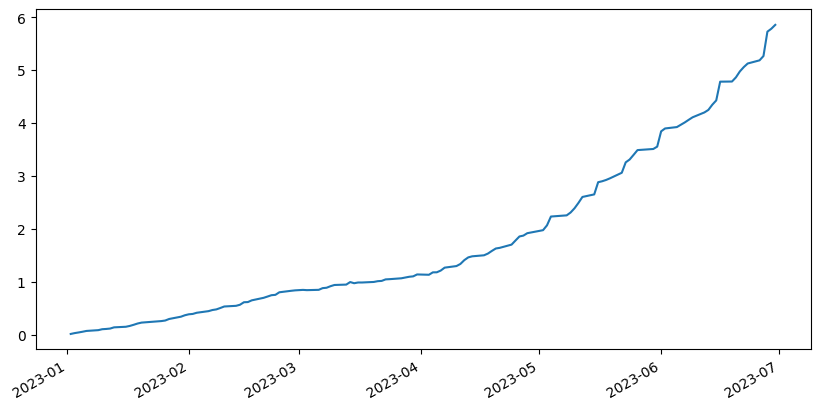

In [27]:
plt.figure(figsize=(10, 5))
np.expm1(np.log1p(port_ret).cumsum()).plot.line()

In [28]:
def sr(ret):
    
    return (ret.iloc[:].mean()  - (0.035/252)) / ret.iloc[:].std()

### Total Sharpe Ratio

In [29]:
print("Sharpe Ratio (All Range)")
sr(port_ret)

Sharpe Ratio (All Range)


1.1768831562962647

### Monthly Sharpe Ratio

In [30]:
print("Sharpe Ratio (Monthly)")
port_ret.resample("m").apply(sr)

Sharpe Ratio (Monthly)


2023-01-31    2.360782
2023-02-28    1.806131
2023-03-31    0.882663
2023-04-30    1.646475
2023-05-31    1.343261
2023-06-30    0.964119
Freq: M, dtype: float64

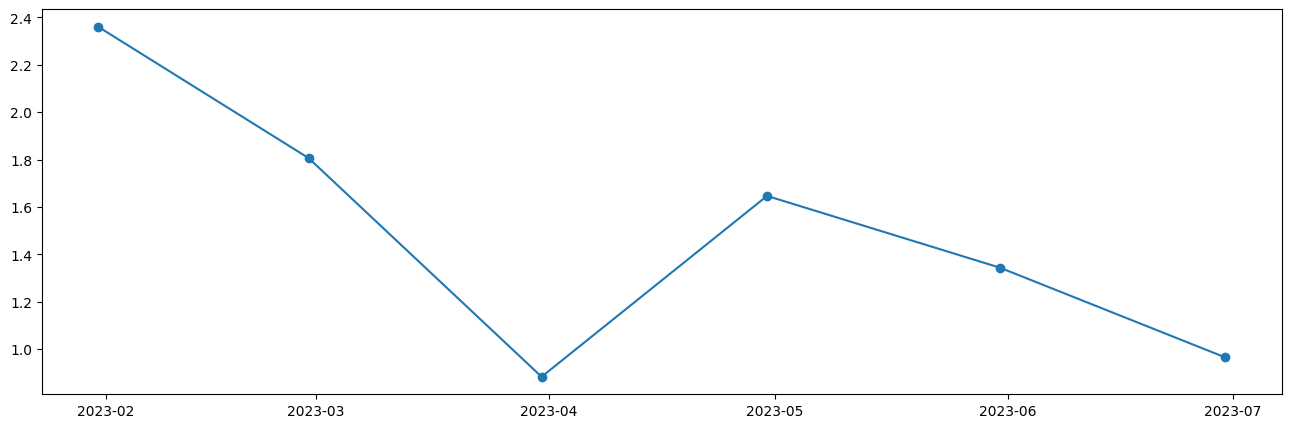

In [31]:
plt.figure(figsize=(16, 5))
plt.plot(port_ret.resample("m").apply(sr), marker="o")

In [32]:
print("Sharpe Ratio (Weekly)")
port_ret.resample("w").apply(sr)

Sharpe Ratio (Weekly)


2023-01-08    9.659090
2023-01-15    1.827970
2023-01-22    3.575956
2023-01-29    2.130321
2023-02-05    1.662960
2023-02-12    3.100016
2023-02-19    1.350480
2023-02-26    1.711922
2023-03-05    0.723636
2023-03-12    1.566234
2023-03-19    0.360687
2023-03-26    1.248855
2023-04-02    1.658588
2023-04-09    0.939585
2023-04-16    2.094428
2023-04-23    1.958089
2023-04-30    2.100428
2023-05-07    1.954502
2023-05-14    2.107690
2023-05-21    0.761364
2023-05-28    1.868200
2023-06-04    0.802657
2023-06-11    2.022494
2023-06-18    1.108419
2023-06-25    1.666797
2023-07-02    0.813033
Freq: W-SUN, dtype: float64

### Weekly Sharpe Ratio

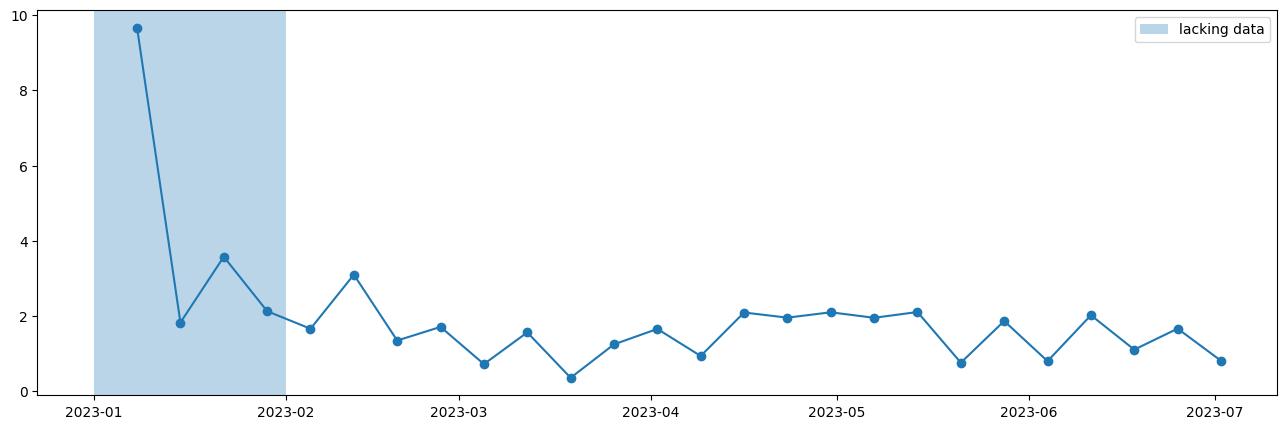

In [33]:
plt.figure(figsize=(16, 5))
plt.plot(port_ret.resample("w").apply(sr), marker="o")
plt.axvspan("2023-01", "2023-02", alpha=0.3, label="lacking data")
plt.legend()

## Submission

Code for submission.

In [34]:
dates2 = list(pd.date_range("2022-06", "2023-08", freq="m").to_period("m").astype(str))

In [35]:
X_train, y_train = df[df["일자"].isin(dates2[:-1])].drop(["일자", "종목코드", "value", "liquidity1"], axis=1), df[df["일자"].isin(dates2[:-1])]["value"]
X_test, y_test = df[df["일자"] ==  dates2[-1]].drop(["일자", "종목코드", "value", "liquidity1"], axis=1), df[df["일자"] ==  dates2[-1]]["value"]


model = Ridge()
model.fit(X_train, y_train)


w = pd.Series(-model.predict(X_test), index=df[df["일자"] ==  dates2[-1]]["종목코드"].values)

In [36]:
sub = pd.read_csv('sample_submission.csv')

In [37]:
result = pd.DataFrame((w).rank(method='first', ascending=False).astype('int'),index=w.index, columns=["순위"]).astype(int).reset_index()
result = result.rename({"index":"종목코드"}, axis=1)

In [38]:
baseline_submission = sub[['종목코드']].merge(result[['종목코드', '순위']], on='종목코드', how='left')
baseline_submission

,종목코드,순위
0,A000020,1425
1,A000040,1168
2,A000050,380
3,A000070,199
4,A000080,566
...,...,...
1995,A375500,1475
1996,A378850,1584
1997,A383220,1238
1998,A383310,1800


In [39]:
len(baseline_submission.순위.unique())

2000

In [40]:
baseline_submission.to_csv("model_r_good_private_without_liquidity.csv", index=False)

## Financial Economic Clarification: Why Does it Happen?

In this supplementary session, we aim to test which of the two anomaly hypotheses proposed by our team more closely aligns with reality.
To recap, they are as follows:

1. All the risk proxies currently used are already reflected in market prices. Therefore, if a model evaluates that a strong cross-sectional return difference occurred in the future due to the risk proxy, it suggests that there was an overreaction to that particular risk factor in the past. As a result, the returns regress towards the equilibrium price in the opposite direction of the predicted returns.

2. If a risk proxy, which has shown significant influence in the overall market, rises, the priced future returns also increase. However, in real short-term scenarios, when risk increases, prices decrease. Therefore, while the model's prediction may represent long-term equilibrium returns, in a short investment period of about a month, a price drop due to the increase of that risk proxy occurs first.

To verify which of the above is correct, we can design an econometric model as follows:
The first hypothesis speaks of overreaction, while the second refers to underreaction.
Therefore, by examining the relationship between risk proxies and past, present, and future returns, we can determine whether past and future reactions are the same or different based on their reactions. Here, we aim to clarify the relationship between the top five risk proxies that have shown strong predictive power and the current, past, and future returns. 
We cannot specify the exact point of presentation, so we intend to analyze based on the time when the risk proxy can be measured.

The regression formula for the above test is as follows:

$$RP_{t, i} = \alpha + \beta_1 R_{t, i}+ \beta_2 R_{t-1, i}+ \beta_3 R_{t+1, i} + \epsilon_{t+1, i}$$

Where $R_{t, i}$ represents the return of stock i at time t, and $ RP_{t, i}$ is the risk proxy of stock i at time t. The current return is also added to the regression to control for information being reflected not only in the past and future but also at present.

If the first hypothesis is correct and market efficiency is achieved, then $\beta_1$ and $\beta_2$, or just $\beta_2$, will be statistically significant. While $\beta_3$ might not be statistically significant, economically, its sign would be opposite to $\beta_1$ and $\beta_2$.
If the second hypothesis is correct and market efficiency is not achieved, then $\beta_3$ could be statistically significant. The sign of $\beta_3$ would be the same as $\beta_1$ and $\beta_2$.


In [105]:
X_train, y_train = df[df["일자"].isin(dates2[:-1])].drop(["일자", "종목코드", "value", "liquidity1"], axis=1), df[df["일자"].isin(dates2[:-1])]["value"]

X_train = (X_train - X_train.mean()) / X_train.std()

model = Ridge()
model.fit(X_train, y_train)

pd.Series(model.coef_, index=X_train.columns).abs().sort_values().iloc[::-1].iloc[:5]

생산자물가지수    0.008325
소비자물가지수    0.007708
위안         0.006982
spread     0.005046
뉴스심리지수     0.004592
dtype: float64

When the variables are standardized, the predictive indicators that Ridge regression evaluates most effectively are the Producer Price Index, Consumer Price Index, Chinese Yuan, 10-Year Treasury Bond minus 3-Year Treasury Bond spread, and the News Sentiment Index.

In [106]:
pd.Series(model.coef_, index=X_train.columns).abs().sort_values().iloc[::-1].iloc[:]

생산자물가지수     0.008325
소비자물가지수     0.007708
위안          0.006982
spread      0.005046
뉴스심리지수      0.004592
미국달러        0.004315
momentum    0.003528
vola        0.001685
통안증권        0.001542
유로          0.001481
일본엔         0.001431
ret         0.000995
abnormal    0.000931
경제심리지수      0.000838
dtype: float64

In [109]:
#generating statistical testing dataset
df0 = df.copy()
df0 = df0.rename({"value":"lead"}, axis=1)

#adding current return
tmp = ret.shift(0)
tmp.index = tmp.index.to_period("m").astype(str)
tmp = tmp.reset_index()
tmp = tmp.melt(id_vars="일자", value_vars=tmp.columns).rename({"value":"current"}, axis=1)
df0 = df0.merge(tmp, on=["일자", "종목코드"])

#adding past return
tmp = ret.shift(1)
tmp.index = tmp.index.to_period("m").astype(str)
tmp = tmp.reset_index()
tmp = tmp.melt(id_vars="일자", value_vars=tmp.columns).rename({"value":"lag"}, axis=1)
df0 = df0.merge(tmp, on=["일자", "종목코드"])


In [110]:
df0 = df0.dropna()

### Multivariate Regression Analysis Results

#### Summary

- Producer Price Index: Supports Hypothesis 1
- Consumer Price Index: Supports Hypothesis 1
- Chinese Yuan: Supports Hypothesis 2 (Mixed Results)
- Spread: Supports Hypothesis 1
- News Sentiment Index: Supports Hypothesis 1

Most of the evidence aligns with Hypothesis 1, thus the team aims to emphasize Hypothesis 1 over Hypothesis 2 as the cause for generating the team's strategy returns.


In [111]:
sm.OLS(df0["생산자물가지수"], sm.add_constant(df0[["lead", "current", "lag"]])).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                생산자물가지수   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     40.14
Date:                Sat, 29 Jul 2023   Prob (F-statistic):           8.07e-26
Time:                        16:45:08   Log-Likelihood:                -55925.
No. Observations:               14000   AIC:                         1.119e+05
Df Residuals:                   13996   BIC:                         1.119e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.0496      0.114    -26.723      0.000      -3.273      -2.826
lead           2.1140      0.734      2.881      0.004       0.676       3.552
current        0.4675      0.751      0.622      0.534      -1.005       1.940
lag           -7.8516      0.746    -10.519      0.000      -9.315      -6.388
==============================================================================
Omnibus:                    31115.973   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        247607779.492
Skew:                          20.575   Prob(JB):                         0.00
Kurtosis:                     653.213   Cond. No.                         6.97
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [112]:
sm.OLS(df0["소비자물가지수"], sm.add_constant(df0[["lead", "current", "lag"]])).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                소비자물가지수   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     20.59
Date:                Sat, 29 Jul 2023   Prob (F-statistic):           2.62e-13
Time:                        16:45:13   Log-Likelihood:                -63998.
No. Observations:               14000   AIC:                         1.280e+05
Df Residuals:                   13996   BIC:                         1.280e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.9504      0.203    -44.059      0.000      -9.349      -8.552
lead           1.9390      1.306      1.485      0.138      -0.621       4.499
current       -0.5202      1.338     -0.389      0.697      -3.142       2.102
lag          -10.2628      1.329     -7.724      0.000     -12.867      -7.658
==============================================================================
Omnibus:                    24868.928   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         54152109.047
Skew:                          12.545   Prob(JB):                         0.00
Kurtosis:                     306.649   Cond. No.                         6.97
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [113]:
sm.OLS(df0["위안"], sm.add_constant(df0[["lead", "current", "lag"]])).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     위안   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     12.55
Date:                Sat, 29 Jul 2023   Prob (F-statistic):           3.41e-08
Time:                        16:45:16   Log-Likelihood:                -33617.
No. Observations:               14000   AIC:                         6.724e+04
Df Residuals:                   13996   BIC:                         6.727e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4176      0.023     61.122      0.000       1.372       1.463
lead           0.9115      0.149      6.112      0.000       0.619       1.204
current       -0.0492      0.153     -0.322      0.748      -0.348       0.250
lag           -0.0754      0.152     -0.497      0.619      -0.373       0.222
==============================================================================
Omnibus:                    22513.325   Durbin-Watson:                   1.932
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         46416004.215
Skew:                          10.047   Prob(JB):                         0.00
Kurtosis:                     284.365   Cond. No.                         6.97
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [114]:
sm.OLS(df0["spread"], sm.add_constant(df0[["lead", "current", "lag"]])).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 spread   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     28.69
Date:                Sat, 29 Jul 2023   Prob (F-statistic):           1.74e-18
Time:                        16:45:19   Log-Likelihood:                -20702.
No. Observations:               14000   AIC:                         4.141e+04
Df Residuals:                   13996   BIC:                         4.144e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3301      0.009    -35.799      0.000      -0.348      -0.312
lead          -0.0832      0.059     -1.404      0.160      -0.199       0.033
current       -0.2137      0.061     -3.521      0.000      -0.333      -0.095
lag            0.4959      0.060      8.223      0.000       0.378       0.614
==============================================================================
Omnibus:                    24305.029   Durbin-Watson:                   1.945
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         96269204.667
Skew:                         -11.627   Prob(JB):                         0.00
Kurtosis:                     408.576   Cond. No.                         6.97
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [115]:
sm.OLS(df0["뉴스심리지수"], sm.add_constant(df0[["lead", "current", "lag"]])).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 뉴스심리지수   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     8.442
Date:                Sat, 29 Jul 2023   Prob (F-statistic):           1.33e-05
Time:                        16:45:22   Log-Likelihood:                -12255.
No. Observations:               14000   AIC:                         2.452e+04
Df Residuals:                   13996   BIC:                         2.455e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3182      0.005    -63.100      0.000      -0.328      -0.308
lead          -0.0831      0.032     -2.562      0.010      -0.147      -0.020
current        0.0061      0.033      0.184      0.854      -0.059       0.071
lag            0.1432      0.033      4.342      0.000       0.079       0.208
==============================================================================
Omnibus:                     8798.547   Durbin-Watson:                   1.875
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2030240.209
Skew:                          -1.921   Prob(JB):                         0.00
Kurtosis:                      61.870   Cond. No.                         6.97
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""